In [1]:
#experiment name and snapshot folder (used for model persistence)
experiment_setup_name = "tutorial.wikicat.advanced"
snapshot_path = "./agentnet_snapshots/"
!mkdir ./agentnet_snapshots

mkdir: cannot create directory `./agentnet_snapshots': File exists


In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


#theano imports
#the problem is too simple to be run on GPU. Seriously.
%env THEANO_FLAGS='device=cpu'
import theano
import theano.tensor as T
floatX = theano.config.floatX

import lasagne


env: THEANO_FLAGS='device=cpu'


In [3]:
%load_ext autoreload
%autoreload 2

# This tutorial builds above the basic tutorial and shows several advanced tools
* multi-layer (and in principle, arbitrary) agent memory
* different reinforcement learning algorithms
* model persistence

__[todo: add more]__


# Experiment setup
* Here we load an experiment environment (description below)
* Designing one from scratch is explained in later tutorials

In [4]:
import agentnet.experiments.wikicat as experiment
print experiment.__doc__


This experiment Wikipedia data sample on musicians, scraped via the scripts present in this directory. 
For each musician, we know a number of boolean features (factors) on various topics like 
 * whether or not he/she was active in 1990's, 2000's, etc.
 * whether or not he/she plays guitar, piano, etc
 * whether or not he/she was born in 50's, 60's, etc.
 * what wikipedia categories does he/she belong to
 etc.



In the initial moment of time, agent knows nothing about any of them.
At each turn, agent may decide to
 - "open" one of the hidden factors.
   - if the factor turns out to be 1, agent receives +3 reward for Wikipedia categories, +1 for other categories,
   - Otherwise, the reward equals -1 for Wikipedia categories, -1 for other categores
   - all these rewards are parameterisable during environment creation
 - decide to quit session
   - yields reward of 0 and ends the interaction.
   - all farther actions will have no effect until next session

It is expected, that in orde

In [5]:
#Create an environment with all default parameters
env = experiment.WikicatEnvironment()

In [6]:
from sklearn.cross_validation import train_test_split
attrs, categories, feature_names = env.get_dataset(experiment_path="")

train_attrs,test_attrs,train_cats,test_cats = train_test_split(attrs,categories,test_size=0.99,random_state=32)

print "train size:", train_attrs.shape,train_cats.shape
print "train size:", test_attrs.shape,test_cats.shape

print "features:",feature_names[::20]

train size: (85, 300) (85, 93)
train size: (8509, 300) (8509, 93)
features: ['Children:is_known', 'Instruments:vocals', 'Genres:electronic', 'Origin:scotland', 'Genres:jazz', 'Genres:electric', 'Occupation:bassist', 'Instruments:violin', 'Genres:instrumental', 'Occupation:entrepreneur', 'Instruments:mandolin', 'Instruments:vocalist', 'Genres:synthpop', 'decades_active:1990', 'Occupation:remixer', 'category:List_of_musical_artists_from_Japan', 'category:List_of_ambient_music_artists', 'category:List_of_crooners', 'category:List_of_country_music_performers', 'category:List_of_bass_guitarists']


In [7]:
env.load_random_batch(train_attrs,train_cats,5)

# agent setup
* An agent implementation has to contain three parts:
 * Memory layer(s)
  * in this case, we train two GRU layers [details below]
 * Q-values evaluation layers
  * in this case, a lasagne dense layer based on memory layer
 * Resolver - acton picker layer
  * in this case, the resolver has epsilon-greedy policy
  
  
### two-layer memory architecture
We train two memory states:
  * first one, based on observations,
  * second one, based on first one;

Note that here we update the second memory layer based on the CURRENT state
of the first one. Instead, you can try to feed it with a previous state.

The q-values are estimated on a concatenated state, effectively on both memory
states together, but there is no problem with limiting q-evaluator to only one:
just pass the correct gru layer as an incoming layer to the q-evaluator.

### Implementation:
We concatenate both memories into 1 state to pass it through the session loop.

To perform memory update, we need to slice the concatenated state back into
two memory states.

We do so by defining an input map function and passing it into agent.

We than concatenate two new states back to form a new memory state.



In [8]:
from agentnet.resolver import EpsilonGreedyResolver
from agentnet.memory import GRUMemoryLayer
from agentnet.agent import Agent

In [9]:
import lasagne
n_hid_1=128 #first GRU memory
n_hid_2=64 #second GRU memory


_observation_layer = lasagne.layers.InputLayer([None]+list(env.observation_shapes),name="obs_input")

_prev_gru1_layer = lasagne.layers.InputLayer([None,n_hid_1],name="prev_gru1_state_input")
_prev_gru2_layer = lasagne.layers.InputLayer([None,n_hid_2],name="prev_gru2_state_input")

#memory
gru1 = GRUMemoryLayer(n_hid_1,
                     _observation_layer,
                     _prev_gru1_layer,
                     name="gru1")

gru2 = GRUMemoryLayer(n_hid_2,
                     gru1,        #note that it takes CURRENT gru1 output as input.
                                  #replacing that with _prev_gru1_state would imply taking previous one.
                     _prev_gru2_layer,
                     name="gru2")

concatenated_memory = lasagne.layers.concat([gru1,gru2])

#q_eval
n_actions = len(feature_names)
q_eval = lasagne.layers.DenseLayer(concatenated_memory, #taking both memories. 
                                                        #Replacing with gru1 or gru2 would mean taking one
                                   num_units = n_actions,
                                   nonlinearity=lasagne.nonlinearities.linear,name="QEvaluator")
#resolver
epsilon = theano.shared(np.float32(0.1),"e-greedy.epsilon")

resolver = EpsilonGreedyResolver(q_eval,epsilon=epsilon,name="resolver")



from collections import OrderedDict
#all together
agent = Agent(_observation_layer,
              OrderedDict([
                    (gru1,_prev_gru1_layer),
                    (gru2,_prev_gru2_layer)
              ]),
              q_eval,resolver)


In [10]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[gru1.W_in_to_updategate,
 gru1.W_hid_to_updategate,
 gru1.b_updategate,
 gru1.W_in_to_resetgate,
 gru1.W_hid_to_resetgate,
 gru1.b_resetgate,
 gru1.W_in_to_hidden_update,
 gru1.W_hid_to_hidden_update,
 gru1.b_hidden_update,
 gru2.W_in_to_updategate,
 gru2.W_hid_to_updategate,
 gru2.b_updategate,
 gru2.W_in_to_resetgate,
 gru2.W_hid_to_resetgate,
 gru2.b_resetgate,
 gru2.W_in_to_hidden_update,
 gru2.W_hid_to_hidden_update,
 gru2.b_hidden_update,
 QEvaluator.W,
 QEvaluator.b]

## Agent setup in detail
* __Memory layers__
 * One-step recurrent layer
     * takes input and one's previous state
     * returns new memory state
   * Can be arbitrary lasagne layer
   * Several one-step recurrent units are implemented in __agentnet.memory__
   * Note that lasagne's default recurrent networks roll for several steps at once
     * in other words, __using lasagne recurrent units as memory means recurrence inside recurrence__
 * Using more than one memory layer is explained in farther tutorials


* __Q-values evaluation layer__
 * Can be arbitrary lasagne network
 * returns predicted Q-values for each action
 * Usually depends on memory as an input


* __Resolver__ - action picker
 * Decides on what action is taken
 * Normally takes Q-values as input
 * Currently all experiments require integer output
 * Several resolver layers are implemented in __agentnet.resolver__

# Interacting with environment
* an agent has a method that produces symbolic environment interaction sessions
* interactions result in sequences of observations, actions, q-values,etc
* one has to pre-define maximum session length.
 * in this case, environment implements an indicator of whether session has ended by current tick
* Since this environment also implements Objective methods, it can evaluate rewards for each [batch, time_tick]


In [11]:
#produce interaction sequences of length <= 10
(state_seq,),observation_seq,agent_state,action_seq,qvalues_seq = agent.get_sessions(
    env,
    session_length=10,
    batch_size=env.batch_size,
)


gru1_seq = agent_state[gru1]
gru2_seq = agent_state[gru2]

#get rewards for all actions
rewards_seq = env.get_reward_sequences(state_seq,action_seq)

#get indicator whether session is still active
is_alive_seq = env.get_whether_alive(observation_seq)


# Evaluating loss function
* This part is similar to the basic tutorial but for the fact that we use 3-step q-learning

* we evaluate the Q-loss manually, so this entire block is in essence equivalent to `qlearning_n_step.get_elementwise_objective(...)`
 
 
 #### Get (prediction,reference) pairs

In [12]:
#get reference Qvalues according to Qlearning algorithm


from agentnet.learning import qlearning_n_step

#gamma - delayed reward coefficient - what fraction of reward is retained if it is obtained one tick later
gamma = theano.shared(np.float32(0.95),name = 'q_learning_gamma')


reference_Qvalues = qlearning_n_step.get_reference_Qvalues(qvalues_seq,
                               action_seq,
                               rewards_seq,
                               n_steps=3,
                               gamma_or_gammas=gamma,)

In [13]:
#zero-out future rewards at session end
from agentnet.utils.mdp import get_end_indicator

end_action_ids = get_end_indicator(is_alive_seq).nonzero()

# "set reference Qvalues at end action ids to just the immediate rewards"
reference_Qvalues = T.set_subtensor(reference_Qvalues[end_action_ids],
                                    rewards_seq[end_action_ids])

In [14]:
#prevent gradient updates over reference Qvalues (since they depend on predicted Qvalues)
from theano.gradient import disconnected_grad
reference_Qvalues = disconnected_grad(reference_Qvalues)

In [15]:
from agentnet.utils.mdp import get_action_Qvalues
action_Qvalues = get_action_Qvalues(qvalues_seq,action_seq)

#### Define loss functions

In [16]:
#tensor of elementwise squared errors
squared_error = lasagne.objectives.squared_error(reference_Qvalues,action_Qvalues)

#zero-out ticks after session ended
squared_error = squared_error * is_alive_seq

#all code from Evaluation Loss Function beginning to this point is equivalent to
#squared_error = qlearning_n_step.get_elementwise_objective(...)


#compute average of squared error sums per session
mse_loss = squared_error.sum() / is_alive_seq.sum()

In [17]:
#regularize network weights

from lasagne.regularization import regularize_network_params, l2
reg_l2 = regularize_network_params(resolver,l2)*10**-4

In [18]:
loss = mse_loss + reg_l2

#### Compute weight updates

In [19]:

updates = lasagne.updates.adadelta(loss,
                                             weights,learning_rate=0.01)

#### Some auxilary evaluation metrics

In [20]:
mean_session_reward = rewards_seq.sum(axis=1).mean()
#...

# Compile train and evaluation functions

In [21]:
train_fun = theano.function([],[loss,mean_session_reward],updates=updates)

evaluation_fun = theano.function([],[loss,mse_loss,reg_l2,mean_session_reward])

# session visualization tools


* this is a completely optional step of visualizing agent's sessions as chains of actions
* usually useful to get insight on what worked and what din't
* in this case, we print strings following pattern
  * [action_name] ([predicted action qvalue]) -> reward [reference qvalue] | next iteration

* plot shows
    * time ticks over X, abstract values over Y
    * bold lines are Qvalues for actions
    * dots on bold lines represent what actions were taken at each moment of time
    * dashed lines are agent's hidden state neurons
    * blue vertical line - session end
    
    
__Warning! the visualization tools are underdeveloped and only allow simple operations.__

if you found yourself struggling to make it do what you want for 5 minutes, go write your own tool [and contribute it :)]


In [22]:
from agentnet.display.sessions import print_sessions
get_printables = theano.function([], [
        gru2_seq,qvalues_seq, action_seq,rewards_seq,reference_Qvalues,is_alive_seq
    ])

def display_sessions(with_plots = False):
        
    hidden_log,qvalues_log,actions_log,reward_log, reference_qv_log, is_alive_log = get_printables()
    
    
    print_sessions(qvalues_log,actions_log,reward_log,
                   is_alive_seq = is_alive_log,
                   #hidden_seq=hidden_log, #do not plot hidden since there's too many actions already
                   reference_policy_seq = reference_qv_log,
                   action_names=feature_names,
                   legend = False, #do not show legend since there's too many labeled objects
                  plot_policy = with_plots)

session # 0
 Children:is_known(qv = 0.0) -> -1.0(ref = -0.899346411228) |  Genres:garage(qv = 0.105951160192) -> -1.0(ref = -0.928636372089) |  Genres:melodic(qv = 0.104983069003) -> -1.0(ref = 0.0751196146011) |  Genres:big(qv = 0.124290555716) -> 1.0(ref = 1.13170492649) |  decades_active:1980(qv = 0.138636767864) -> 1.0(ref = -0.694935560226) |  Genres:fusion(qv = 0.184897869825) -> -1.0(ref = -1.78414273262) |  Genres:contemporary(qv = -0.0778743177652) -> -1.0(ref = -0.825413346291) |  Instruments:alto(qv = 0.183775395155) -> 1.0(ref = 0.0500000119209) |  last_activity:1989(qv = -0.178515344858) -> -1.0(ref = -1.0) |  Genres:industrial(qv = 0.171828746796) -> 0.0(ref = 0.0) | reached max session length


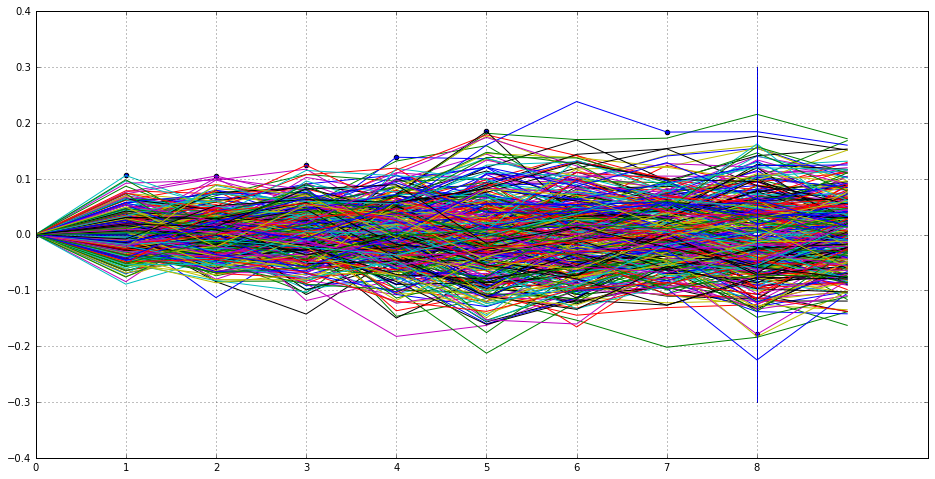

In [23]:
#visualize untrained network performance (which is mostly random)
env.load_random_batch(train_attrs,train_cats,1)
display_sessions(with_plots=True)

# Training loop

In [24]:
#tools for model persistence (in progress now. Requires unique names)
from agentnet.utils.persistence import save,load
import os

In [25]:
from agentnet.display import Metrics
score_log = Metrics()

In [ ]:
#starting epoch
epoch_counter = 1

#moving average estimation
alpha = 0.1
ma_reward_current = -7.
ma_reward_greedy = -7.

epoch 100,loss 2.96037, epsilon 0.99055, rewards: ( e-greedy -7.14000, greedy -7.03000) 
rec 2.697 reg 0.264
epoch 200,loss 2.73929, epsilon 0.98119, rewards: ( e-greedy -7.15600, greedy -6.86700) 
rec 2.476 reg 0.264
epoch 300,loss 2.71714, epsilon 0.97192, rewards: ( e-greedy -7.22040, greedy -6.80530) 
rec 2.454 reg 0.264
epoch 400,loss 2.57127, epsilon 0.96275, rewards: ( e-greedy -7.12836, greedy -6.69477) 
rec 2.308 reg 0.263
epoch 500,loss 3.06911, epsilon 0.95367, rewards: ( e-greedy -7.25552, greedy -6.56529) 
rec 2.806 reg 0.263
epoch 600,loss 2.71867, epsilon 0.94468, rewards: ( e-greedy -7.29997, greedy -6.57376) 
rec 2.455 reg 0.263
epoch 700,loss 2.84276, epsilon 0.93577, rewards: ( e-greedy -7.34997, greedy -6.51639) 
rec 2.580 reg 0.263
epoch 800,loss 2.81980, epsilon 0.92696, rewards: ( e-greedy -7.42498, greedy -6.43975) 
rec 2.557 reg 0.263
epoch 900,loss 2.66335, epsilon 0.91823, rewards: ( e-greedy -7.39748, greedy -6.17077) 
rec 2.400 reg 0.263
epoch 1000,loss 2.8

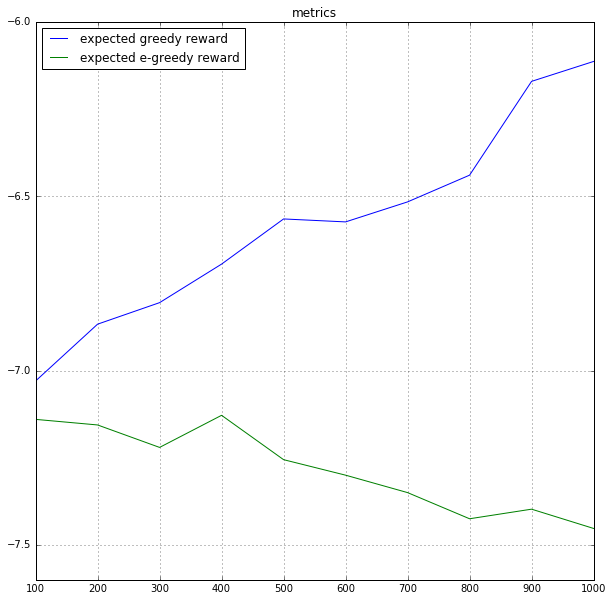

Random session examples
session # 0
 Instruments:organ(qv = -0.00846816040576) -> -1.0(ref = -0.907490193844) |  Genres:thrash(qv = -0.100722938776) -> -1.0(ref = -2.74915647507) |  Instruments:guitar(qv = -0.0745122209191) -> -1.0(ref = -1.84121751785) |  Awards:is_known(qv = -0.0266220234334) -> -1.0(ref = -0.885492146015) |  decades_active:before_1920(qv = -0.0589145347476) -> -1.0(ref = -2.71861815453) |  Occupation:saxophonist(qv = 0.119809560478) -> -1.0(ref = -1.80907177925) |  Genres:soft(qv = -0.0114036966115) -> -1.0(ref = -0.851654469967) |  category:List_of_J-pop_artists(qv = 0.0339496210217) -> -1.0(ref = -1.95000004768) |  Instruments:vocals(qv = -0.0183107536286) -> -1.0(ref = -1.0) |  decades_active:before_1920(qv = -0.053454156965) -> 0.0(ref = 0.0) | reached max session length
session # 1
 Instruments:drum(qv = -0.00674253189936) -> -1.0(ref = -0.91023004055) |  Genres:celtic(qv = -0.033457968384) -> -1.0(ref = -2.73011445999) |  Residence:is_known(qv = 0.031947217881

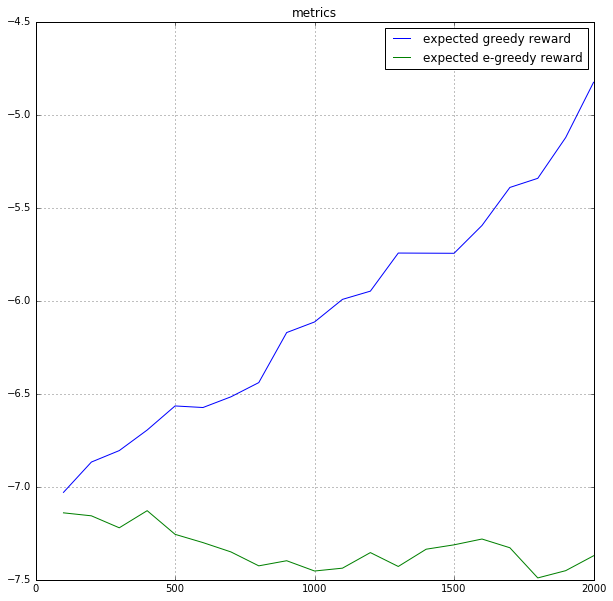

Random session examples
session # 0
 Origin:india(qv = -0.0208629816771) -> -1.0(ref = -0.940693378448) |  first_activity:1968(qv = -0.0531268194318) -> -1.0(ref = -2.76793980598) |  Political party:is_known(qv = -0.0360037460923) -> -1.0(ref = -1.8609893322) |  Genres:nu(qv = -0.0413105152547) -> -1.0(ref = -0.906304478645) |  Occupation:poet(qv = -0.171060785651) -> -1.0(ref = -2.67907381058) |  Genres:latin(qv = -0.0266587436199) -> -1.0(ref = -1.76744604111) |  Instruments:saxophone(qv = -0.00810333900154) -> -1.0(ref = -0.8078379035) |  Labels:is_known(qv = 0.202275872231) -> 1.0(ref = 0.524999976158) |  Labels:is_known(qv = 0.139576911926) -> -0.5(ref = -0.5) |  Origin:california(qv = -0.155156180263) -> 0.0(ref = 0.0) | reached max session length
session # 1
 first_activity:1947(qv = -0.0291736815125) -> -1.0(ref = -0.926334500313) |  category:List_of_jazz_saxophonists(qv = -0.0603127144277) -> -1.0(ref = -2.74568533897) |  Genres:industrial(qv = 0.00467510987073) -> -1.0(ref = 

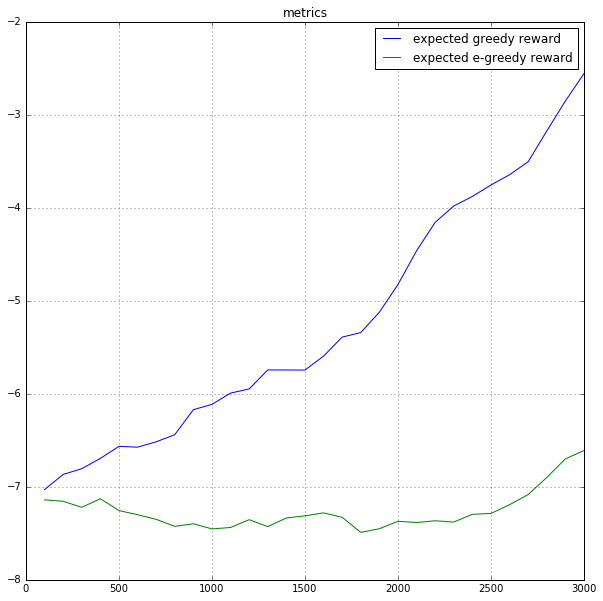

Random session examples
session # 0
 Label(s):is_known(qv = -0.0628410801291) -> -1.0(ref = -0.952870607376) |  Birth name:is_known(qv = 0.0496098995209) -> 1.0(ref = -0.796277403831) |  last_activity:1998(qv = -0.143453806639) -> -1.0(ref = -1.89081835747) |  last_activity:still_active(qv = 0.119001604617) -> -1.0(ref = -0.937703490257) |  last_activity:still_active(qv = 0.0655752494931) -> -0.5(ref = -1.81845927238) |  Genres:ska(qv = -0.0852960348129) -> -1.0(ref = -1.3878518343) |  Birth name:is_known(qv = 0.0970653519034) -> -0.5(ref = -0.408265054226) |  Occupation:comedian(qv = -0.181634634733) -> -1.0(ref = -1.95000004768) |  Origin:australia(qv = -0.488521695137) -> -1.0(ref = -1.0) |  Occupation:guitarist(qv = 0.0337453633547) -> 0.0(ref = 0.0) | reached max session length
session # 1
 Origin:scotland(qv = -0.0607239305973) -> -1.0(ref = -0.935128331184) |  category:List_of_Canadian_composers(qv = -0.0274100452662) -> -1.0(ref = -2.82986545563) |  Origin:u.s.(qv = -0.02798618

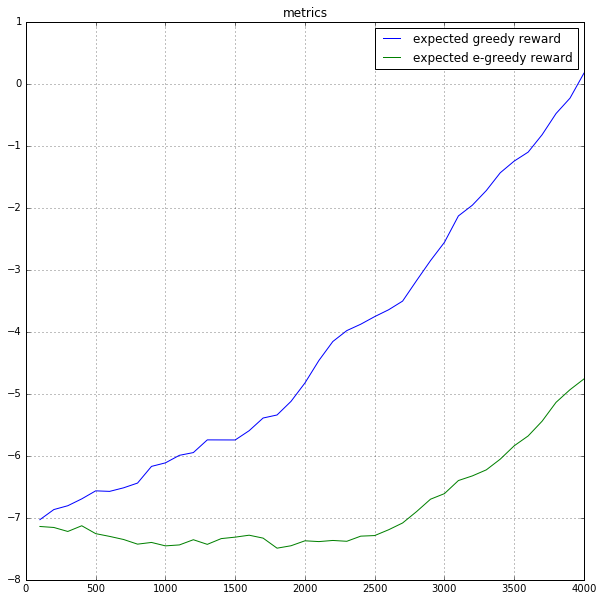

Random session examples
session # 0
 Labels:is_known(qv = 0.0280775967985) -> 1.0(ref = 0.973857402802) |  Origin:los(qv = -0.367456644773) -> -1.0(ref = -0.0339018106461) |  decades_active:2000(qv = 0.00612830556929) -> 1.0(ref = 1.0169454813) |  end_session_now(qv = -0.0109816230834) -> 0.0(ref = 0.0) | 

session # 1
 Origin:germany(qv = -0.087198972702) -> -1.0(ref = -0.978103160858) |  Origin:michigan(qv = -0.258349001408) -> -1.0(ref = 0.0023490190506) |  decades_active:2000(qv = 0.0664917677641) -> 1.0(ref = 1.05510425568) |  end_session_now(qv = 0.0400974862278) -> 0.0(ref = 0.0) | 

session # 2
 Genres:synthpop(qv = -0.161547452211) -> -1.0(ref = -0.97037422657) |  decades_active:2000(qv = 0.0311849992722) -> 1.0(ref = -0.846349000931) |  Genres:celtic(qv = -0.668778836727) -> -1.0(ref = -1.94352531433) |  category:List_of_Arabic_pop_musicians(qv = -0.374871045351) -> -1.0(ref = -0.993184626102) |  Genres:avant-garde(qv = -0.752670168877) -> -1.0(ref = -2.36956763268) |  Instru

In [ ]:
n_epochs = 100000
batch_size= 10

for i in range(n_epochs):    
    
    #train
    env.load_random_batch(train_attrs,train_cats,batch_size)
    resolver.rng.seed(i)    
    loss,avg_reward = train_fun()
    
    
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    if epoch_counter%10 ==0:
        current_epsilon =  0.05 + 0.95*np.exp(-epoch_counter/10000.)
        resolver.epsilon.set_value(np.float32(current_epsilon))
    
    
    
    ##record current learning progress and show learning curves
    if epoch_counter%100 ==0:

        ##update learning curves
        full_loss, q_loss, l2_penalty, avg_reward_current = evaluation_fun()
        ma_reward_current = (1-alpha)*ma_reward_current + alpha*avg_reward_current
        score_log["expected e-greedy reward"][epoch_counter] = ma_reward_current
        
        
        
        #greedy train
        resolver.epsilon.set_value(0)
        avg_reward_greedy = evaluation_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["expected greedy reward"][epoch_counter] = ma_reward_greedy
        
        
        #back to epsilon-greedy
        resolver.epsilon.set_value(np.float32(current_epsilon))

        print "epoch %i,loss %.5f, epsilon %.5f, rewards: ( e-greedy %.5f, greedy %.5f) "%(
            epoch_counter,full_loss,current_epsilon,ma_reward_current,ma_reward_greedy)
        print "rec %.3f reg %.3f"%(q_loss,l2_penalty)

    if epoch_counter %1000 ==0:
        print "Learning curves:"
        score_log.plot()


        print "Random session examples"
        env.load_random_batch(train_attrs,train_cats,3)
        display_sessions(with_plots=False)
    
    #save snapshot
    if epoch_counter %10000 ==0:
        snap_name = "{}.epoch{}.pcl".format(os.path.join(snapshot_path,experiment_setup_name), epoch_counter)
        save(resolver,snap_name)
        print "saved", snap_name

        
        
    epoch_counter  +=1

    
# Time to drink some coffee!

# Evaluating results

[autoreload of agentnet.agent.generator failed: Traceback (most recent call last):
  File "/home/jheuristic/thenv/local/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "/home/jheuristic/yozhik/AgentNet/agentnet/agent/generator.py", line 51
    def as_recurrence(self,
      ^
SyntaxError: invalid syntax
]


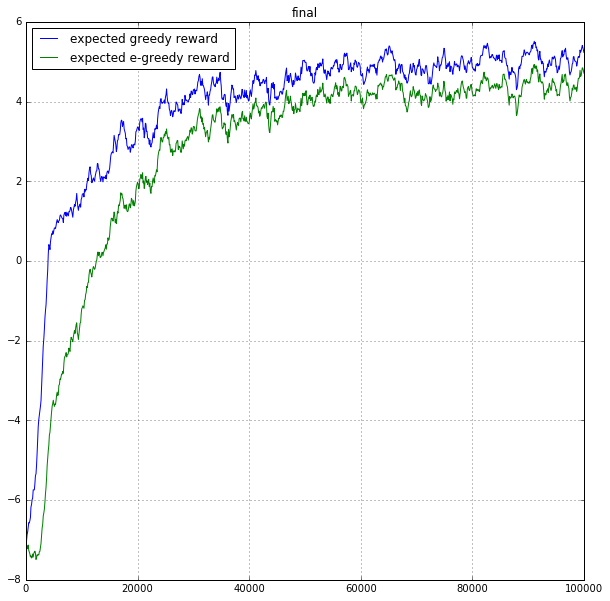

In [32]:
score_log.plot("final")

Random session examples
session # 0
 Labels:is_known(qv = 2.40466403961) -> 1.0(ref = 3.14371013641) |  decades_active:2000(qv = 2.2565369606) -> 1.0(ref = 3.74053096771) |  decades_active:2010(qv = 2.16628670692) -> 1.0(ref = 2.8847694397) |  last_activity:still_active(qv = 1.65644955635) -> 1.0(ref = 1.98396801949) |  Birth name:is_known(qv = 1.03575587273) -> -1.0(ref = 0.969810605049) |  decades_active:1990(qv = 0.786836981773) -> 1.0(ref = 2.07348489761) |  decades_active:1980(qv = 0.309308558702) -> 1.0(ref = 1.12998402119) |  Website:is_known(qv = 0.136825293303) -> 1.0(ref = 0.524999976158) |  decades_active:1980(qv = 0.0814791619778) -> -0.5(ref = -0.5) |  Instruments:vocals(qv = 0.059707518667) -> 0.0(ref = 0.0) | reached max session length


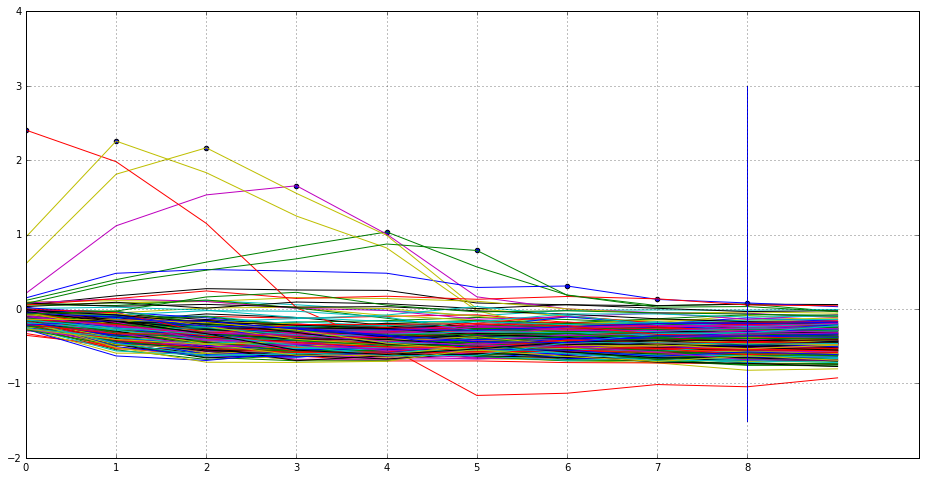

session # 1
 Labels:is_known(qv = 2.40466403961) -> 1.0(ref = 3.14371013641) |  decades_active:2000(qv = 2.2565369606) -> 1.0(ref = 1.84108018875) |  decades_active:2010(qv = 2.16628670692) -> 1.0(ref = 0.885347664356) |  last_activity:still_active(qv = 1.65644955635) -> -1.0(ref = -0.120686650276) |  Birth name:is_known(qv = 0.925593018532) -> -1.0(ref = 0.934244632721) |  decades_active:1990(qv = 0.629390835762) -> 1.0(ref = 2.03604698181) |  decades_active:1980(qv = 0.220027819276) -> 1.0(ref = 1.09057569504) |  Website:is_known(qv = 0.0953428298235) -> 1.0(ref = 1.95000004768) |  Instruments:vocals(qv = 0.0758208185434) -> 1.0(ref = 1.0) |  decades_active:1980(qv = 0.0848581418395) -> 0.0(ref = 0.0) | reached max session length


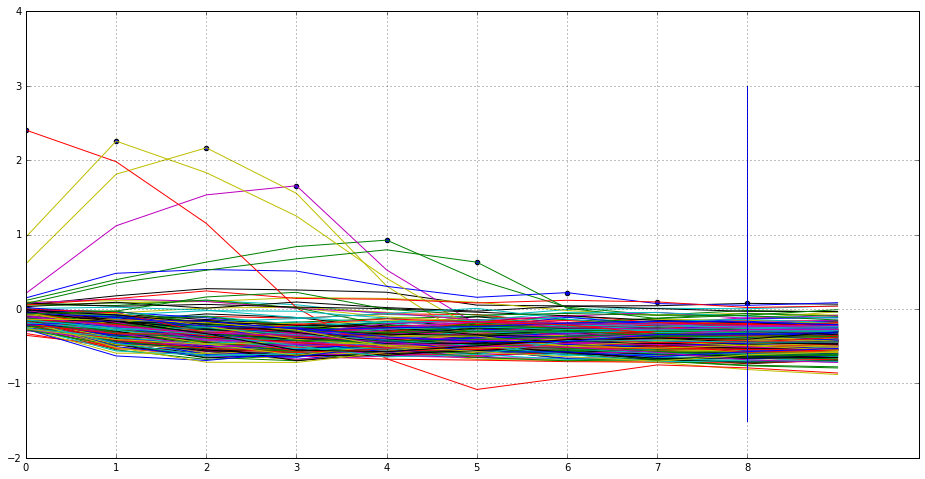

session # 2
 Labels:is_known(qv = 2.40466403961) -> 1.0(ref = 3.14371013641) |  decades_active:2000(qv = 2.2565369606) -> 1.0(ref = 3.74053096771) |  decades_active:2010(qv = 2.16628670692) -> 1.0(ref = 2.8847694397) |  last_activity:still_active(qv = 1.65644955635) -> 1.0(ref = 1.98396801949) |  Birth name:is_known(qv = 1.03575587273) -> -1.0(ref = -0.878810584545) |  decades_active:1990(qv = 0.786836981773) -> 1.0(ref = 0.127567827702) |  first_activity:1953(qv = -0.343007385731) -> -1.0(ref = -0.918349683285) |  Website:is_known(qv = 0.0859477296472) -> 1.0(ref = 0.0500000119209) |  Instruments:vocals(qv = 0.0348549596965) -> -1.0(ref = -1.0) |  Website:is_known(qv = 0.00774814654142) -> 0.0(ref = 0.0) | reached max session length


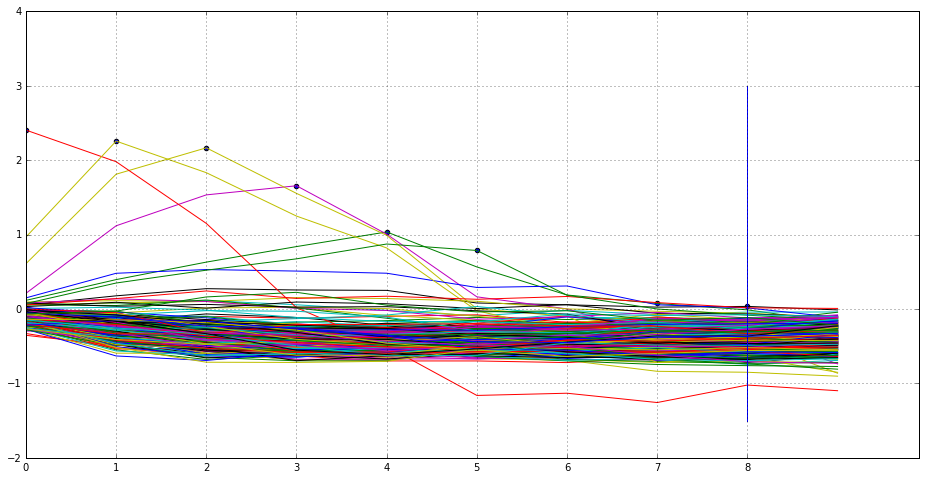

session # 3
 Labels:is_known(qv = 2.40466403961) -> 1.0(ref = 3.14371013641) |  decades_active:2000(qv = 2.2565369606) -> 1.0(ref = 2.02401447296) |  Genres:psychedelic(qv = -0.534085273743) -> -1.0(ref = 1.07790994644) |  decades_active:2010(qv = 1.5963023901) -> 1.0(ref = 2.18727374077) |  last_activity:still_active(qv = 1.24976181984) -> 1.0(ref = 3.15819358826) |  Birth name:is_known(qv = 0.933409571648) -> 1.0(ref = 2.27178263664) |  decades_active:1990(qv = 0.713814496994) -> 1.0(ref = 1.33871853352) |  decades_active:1980(qv = 0.356545805931) -> 1.0(ref = 1.95000004768) |  Website:is_known(qv = 0.16231520474) -> 1.0(ref = 1.0) |  decades_active:1980(qv = 0.090717703104) -> 0.0(ref = 0.0) | reached max session length


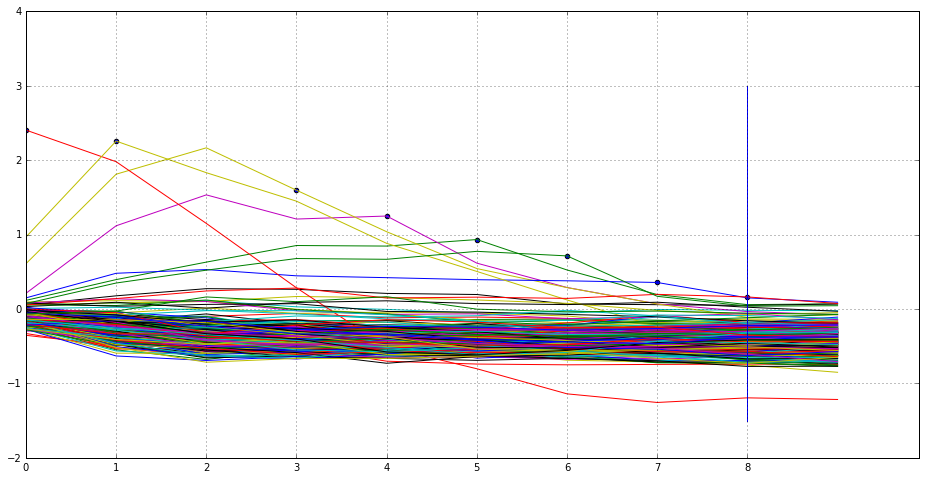

session # 4
 Labels:is_known(qv = 2.40466403961) -> 1.0(ref = 3.14371013641) |  decades_active:2000(qv = 2.2565369606) -> 1.0(ref = 3.74053096771) |  decades_active:2010(qv = 2.16628670692) -> 1.0(ref = 2.8847694397) |  last_activity:still_active(qv = 1.65644955635) -> 1.0(ref = 1.98396801949) |  Birth name:is_known(qv = 1.03575587273) -> 1.0(ref = 3.02991127968) |  decades_active:1990(qv = 0.858678042889) -> 1.0(ref = 2.13674879074) |  decades_active:1980(qv = 0.42901545763) -> 1.0(ref = 1.19657766819) |  decades_active:1980(qv = 0.206923827529) -> -0.5(ref = 0.449999988079) |  Website:is_known(qv = 0.151121601462) -> 1.0(ref = 1.0) |  decades_active:1990(qv = 0.093652151525) -> 0.0(ref = 0.0) | reached max session length


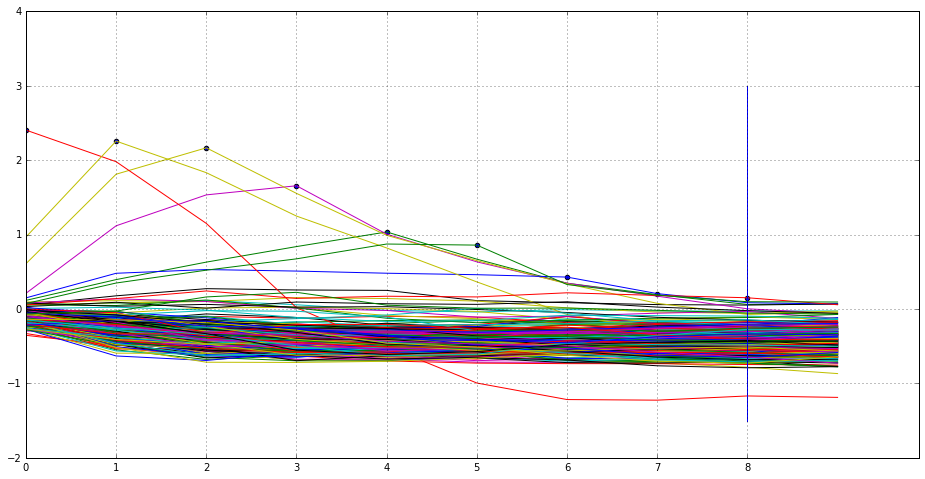

session # 5
 Labels:is_known(qv = 2.40466403961) -> 1.0(ref = 3.14371013641) |  decades_active:2000(qv = 2.2565369606) -> -1.0(ref = -2.36070489883) |  decades_active:2010(qv = 1.45270550251) -> -1.0(ref = -1.43232107162) |  last_activity:still_active(qv = 0.774652242661) -> -1.0(ref = -0.455074846745) |  Birth name:is_known(qv = 0.573605418205) -> -1.0(ref = -2.85003519058) |  decades_active:1990(qv = 0.298523545265) -> -1.0(ref = -1.94740557671) |  Website:is_known(qv = 0.0171349905431) -> -1.0(ref = -0.99726909399) |  Instruments:vocals(qv = 0.0028746239841) -> -1.0(ref = -1.95000004768) |  category:List_of_hip_hop_musicians(qv = 0.0148533396423) -> -1.0(ref = -1.0) |  Genres:r&b(qv = 0.0482079088688) -> 0.0(ref = 0.0) | reached max session length


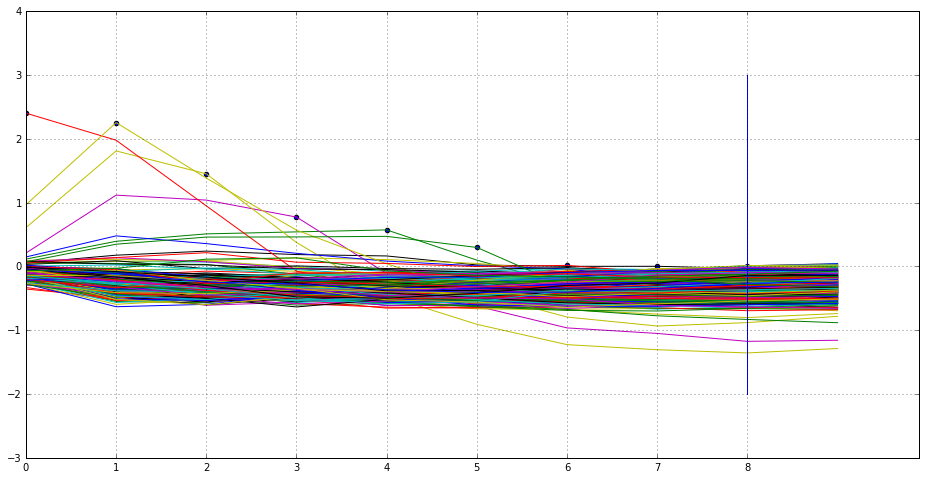

session # 6
 Labels:is_known(qv = 2.40466403961) -> 1.0(ref = 3.14371013641) |  decades_active:2000(qv = 2.2565369606) -> -1.0(ref = -2.36070489883) |  decades_active:2010(qv = 1.45270550251) -> -1.0(ref = -1.43232107162) |  last_activity:still_active(qv = 0.774652242661) -> -1.0(ref = -0.455074846745) |  Birth name:is_known(qv = 0.573605418205) -> -1.0(ref = -2.85003519058) |  decades_active:1990(qv = 0.298523545265) -> -1.0(ref = -1.94740557671) |  Website:is_known(qv = 0.0171349905431) -> -1.0(ref = -0.99726909399) |  Instruments:vocals(qv = 0.0028746239841) -> -1.0(ref = -1.95000004768) |  category:List_of_hip_hop_musicians(qv = 0.0148533396423) -> -1.0(ref = -1.0) |  Genres:r&b(qv = 0.0482079088688) -> 0.0(ref = 0.0) | reached max session length


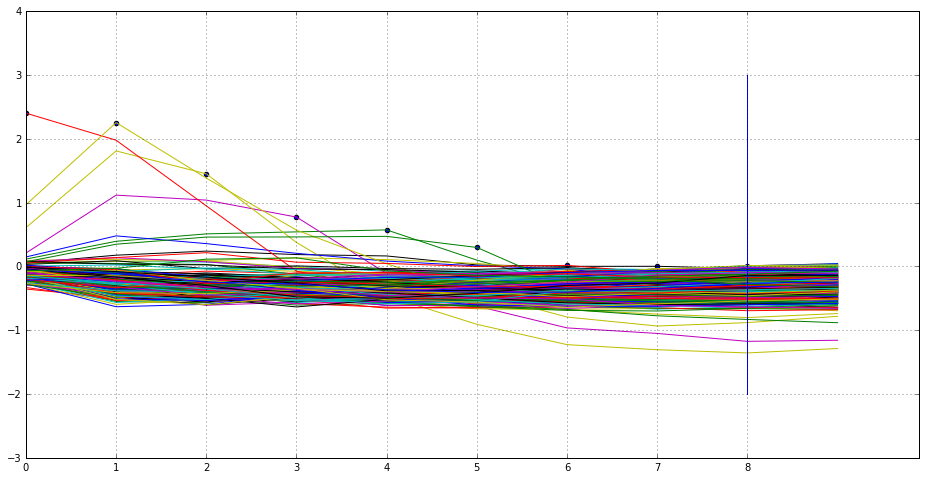

session # 7
 Labels:is_known(qv = 2.40466403961) -> 1.0(ref = 3.14371013641) |  decades_active:2000(qv = 2.2565369606) -> 1.0(ref = 3.74053096771) |  decades_active:2010(qv = 2.16628670692) -> 1.0(ref = 2.8847694397) |  last_activity:still_active(qv = 1.65644955635) -> 1.0(ref = 1.98396801949) |  Birth name:is_known(qv = 1.03575587273) -> -1.0(ref = 0.969810605049) |  decades_active:1990(qv = 0.786836981773) -> 1.0(ref = 2.07348489761) |  decades_active:1980(qv = 0.309308558702) -> 1.0(ref = 1.12998402119) |  Website:is_known(qv = 0.136825293303) -> 1.0(ref = 0.524999976158) |  decades_active:1980(qv = 0.0814791619778) -> -0.5(ref = -0.5) |  Genres:ambient(qv = -0.376034766436) -> 0.0(ref = 0.0) | reached max session length


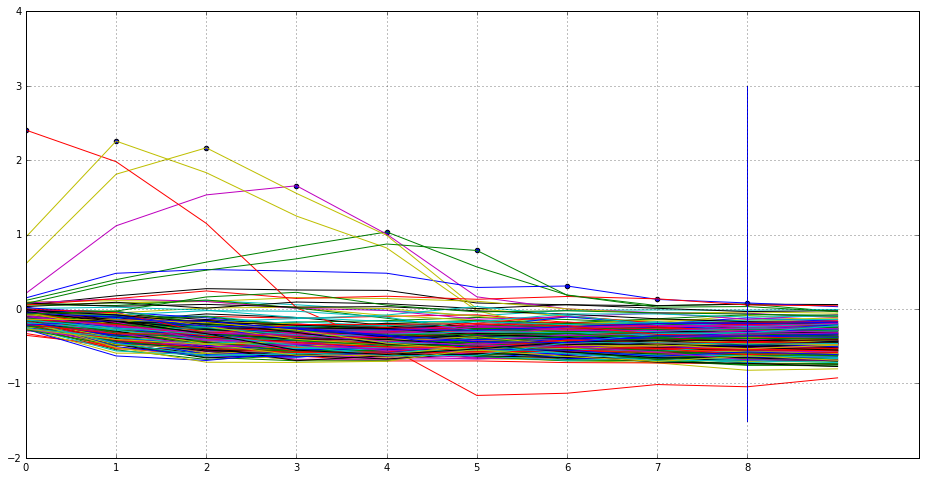

session # 8
 Labels:is_known(qv = 2.40466403961) -> 1.0(ref = 3.14371013641) |  decades_active:2000(qv = 2.2565369606) -> 1.0(ref = 4.10226154327) |  decades_active:2010(qv = 2.16628670692) -> 1.0(ref = 3.26553821564) |  Genres:indie(qv = -0.238434806466) -> 1.0(ref = 2.38477706909) |  decades_active:2010(qv = 1.457660079) -> -0.5(ref = 1.90621399879) |  last_activity:still_active(qv = 1.16032409668) -> 1.0(ref = 2.53285694122) |  Birth name:is_known(qv = 0.881571829319) -> 1.0(ref = 1.61353373528) |  decades_active:1990(qv = 0.64582490921) -> -1.0(ref = -0.0500000119209) |  Website:is_known(qv = 0.144710108638) -> 1.0(ref = 1.0) |  Website:is_known(qv = 0.0257435236126) -> 0.0(ref = 0.0) | reached max session length


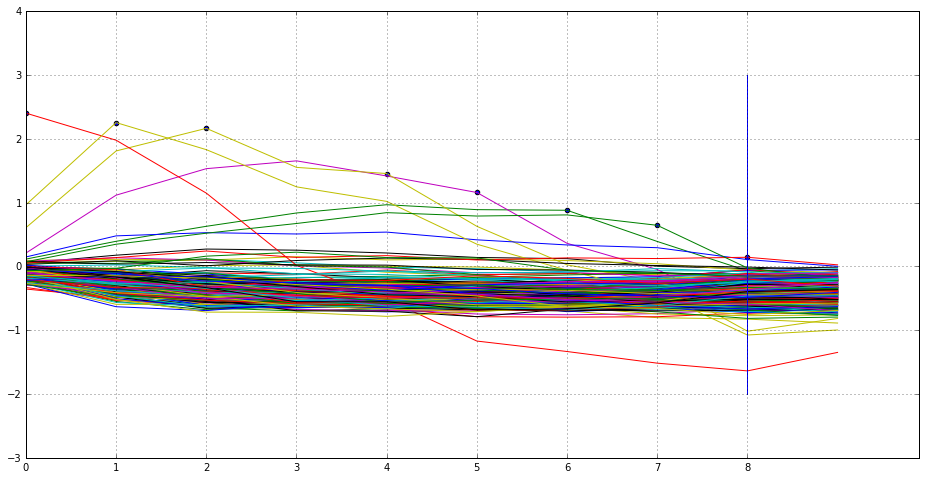

session # 9
 Labels:is_known(qv = 2.40466403961) -> 1.0(ref = 3.14371013641) |  decades_active:2000(qv = 2.2565369606) -> 1.0(ref = 1.78405642509) |  decades_active:2010(qv = 2.16628670692) -> 1.0(ref = 0.825322568417) |  Genres:nu(qv = -0.29795730114) -> -1.0(ref = -0.183870971203) |  last_activity:still_active(qv = 0.859083175659) -> -1.0(ref = -0.929977476597) |  Birth name:is_known(qv = 0.727742314339) -> -1.0(ref = 0.0737079381943) |  decades_active:1990(qv = 0.419007778168) -> 1.0(ref = 1.13021886349) |  decades_active:1980(qv = 0.137072473764) -> 1.0(ref = 1.95000004768) |  Website:is_known(qv = 0.0598406977952) -> 1.0(ref = 1.0) |  Instruments:vocals(qv = 0.087720528245) -> 0.0(ref = 0.0) | reached max session length


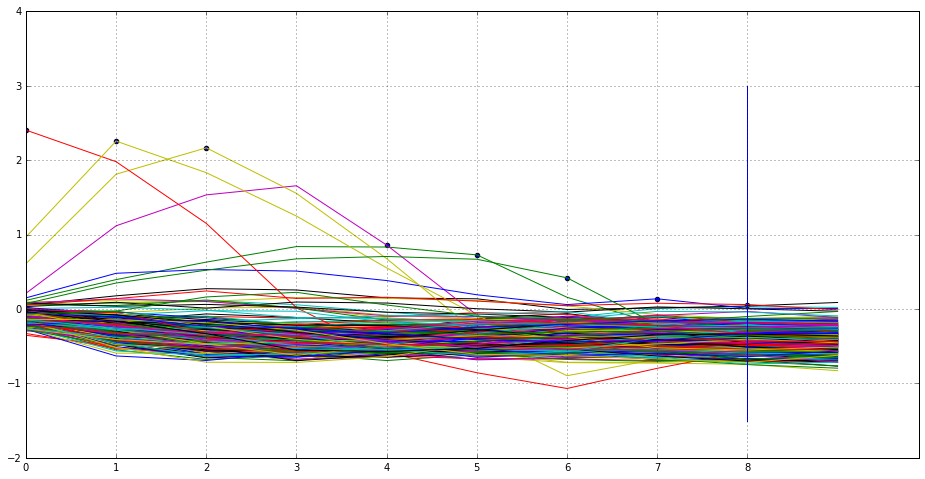

In [33]:
print "Random session examples"
env.load_random_batch(train_attrs,train_cats,10)
display_sessions(with_plots=True)


In [34]:
#load earlier snapshot.
#warning - this overrides the latest network params with earlier ones. 
#Replace 20000 with some 100000 if you wish to load latest snapshot back.
snap_name = "{}.epoch{}.pcl".format(os.path.join(snapshot_path,experiment_setup_name), 20000)
load(resolver,snap_name)

Random session examples
session # 0
 Labels:is_known(qv = 2.40466403961) -> 1.0(ref = 3.14371013641) |  decades_active:2000(qv = 2.2565369606) -> 1.0(ref = 3.74053096771) |  decades_active:2010(qv = 2.16628670692) -> 1.0(ref = 2.8847694397) |  last_activity:still_active(qv = 1.65644955635) -> 1.0(ref = 1.98396801949) |  Birth name:is_known(qv = 1.03575587273) -> -1.0(ref = -0.859794974327) |  decades_active:1990(qv = 0.786836981773) -> 1.0(ref = 0.14758425951) |  decades_active:1980(qv = 0.309308558702) -> -1.0(ref = -0.89727973938) |  Website:is_known(qv = 0.108126588166) -> 1.0(ref = 0.0500000119209) |  Instruments:vocals(qv = 0.0245514474809) -> -1.0(ref = -1.0) |  Website:is_known(qv = -0.0103150494397) -> 0.0(ref = 0.0) | reached max session length


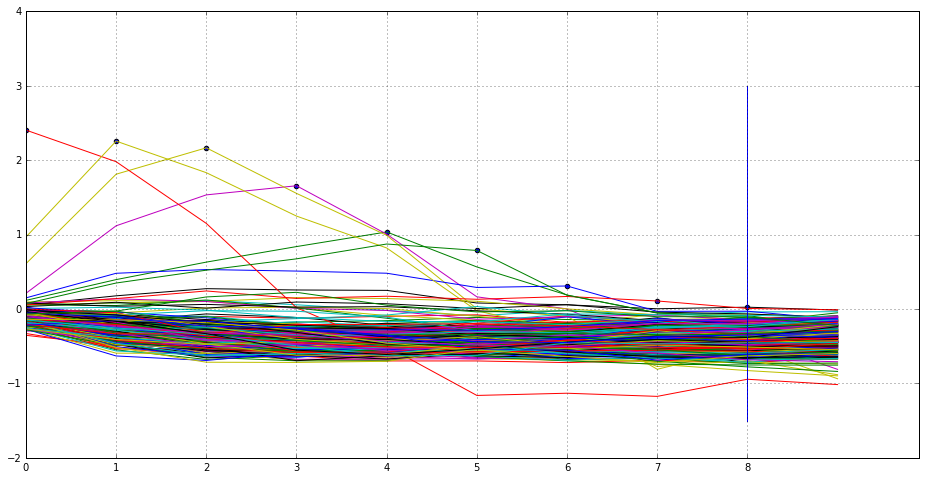

session # 1
 Labels:is_known(qv = 2.40466403961) -> 1.0(ref = 3.14371013641) |  decades_active:2000(qv = 2.2565369606) -> 1.0(ref = 3.74053096771) |  decades_active:2010(qv = 2.16628670692) -> 1.0(ref = 2.8847694397) |  last_activity:still_active(qv = 1.65644955635) -> 1.0(ref = 1.98396801949) |  Birth name:is_known(qv = 1.03575587273) -> 1.0(ref = 1.17906928062) |  decades_active:1990(qv = 0.858678042889) -> 1.0(ref = 0.188493967056) |  decades_active:1980(qv = 0.42901545763) -> -1.0(ref = -0.854216873646) |  Website:is_known(qv = 0.153455927968) -> 1.0(ref = 0.524999976158) |  Website:is_known(qv = 0.0477883331478) -> -0.5(ref = -0.5) |  Instruments:vocals(qv = 0.0368612669408) -> 0.0(ref = 0.0) | reached max session length


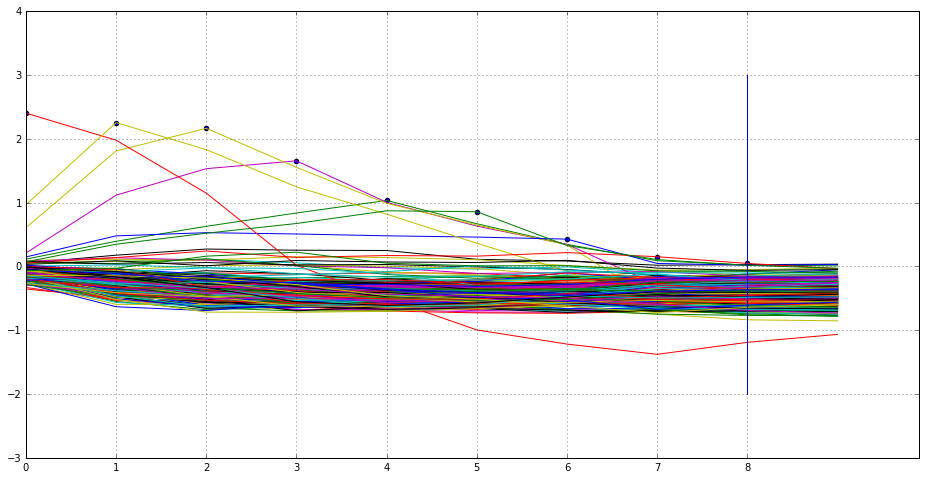

session # 2
 Labels:is_known(qv = 2.40466403961) -> 1.0(ref = 3.14371013641) |  decades_active:2000(qv = 2.2565369606) -> 1.0(ref = 3.74053096771) |  decades_active:2010(qv = 2.16628670692) -> 1.0(ref = 2.8847694397) |  last_activity:still_active(qv = 1.65644955635) -> 1.0(ref = 1.98396801949) |  Birth name:is_known(qv = 1.03575587273) -> 1.0(ref = 3.02991127968) |  decades_active:1990(qv = 0.858678042889) -> 1.0(ref = 2.13674879074) |  decades_active:1980(qv = 0.42901545763) -> 1.0(ref = 1.19657766819) |  decades_active:1980(qv = 0.206923827529) -> -0.5(ref = 0.449999988079) |  Website:is_known(qv = 0.151121601462) -> 1.0(ref = 1.0) |  decades_active:1990(qv = 0.093652151525) -> 0.0(ref = 0.0) | reached max session length


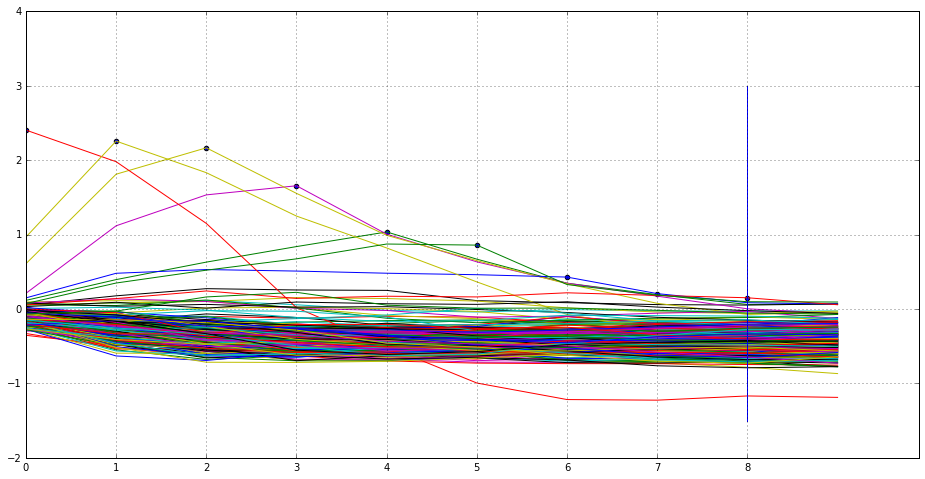

session # 3
 Labels:is_known(qv = 2.40466403961) -> 1.0(ref = 3.14371013641) |  decades_active:2000(qv = 2.2565369606) -> 1.0(ref = 3.74053096771) |  decades_active:2010(qv = 2.16628670692) -> 1.0(ref = 2.8847694397) |  last_activity:still_active(qv = 1.65644955635) -> 1.0(ref = 1.98396801949) |  Birth name:is_known(qv = 1.03575587273) -> 1.0(ref = 1.17906928062) |  decades_active:1990(qv = 0.858678042889) -> 1.0(ref = 0.188493967056) |  decades_active:1980(qv = 0.42901545763) -> -1.0(ref = -0.854216873646) |  Website:is_known(qv = 0.153455927968) -> 1.0(ref = 0.524999976158) |  Website:is_known(qv = 0.0477883331478) -> -0.5(ref = -0.5) |  Instruments:vocals(qv = 0.0368612669408) -> 0.0(ref = 0.0) | reached max session length


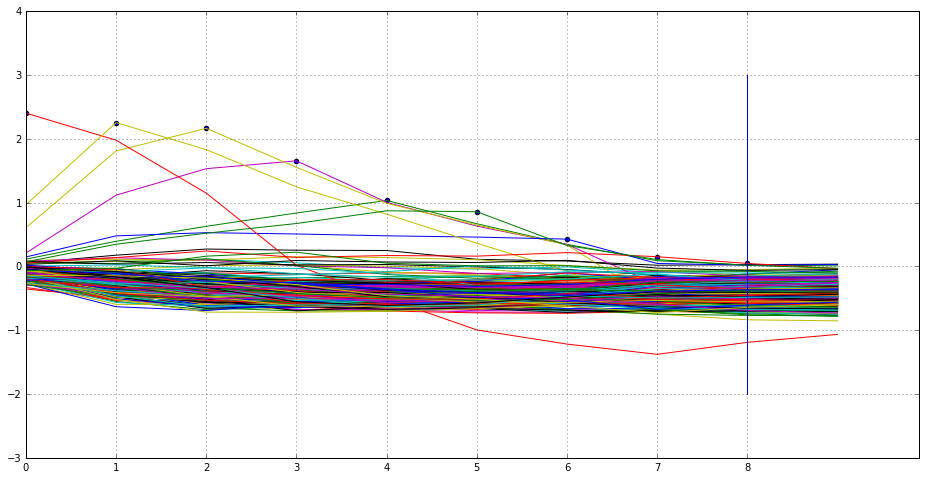

session # 4
 Labels:is_known(qv = 2.40466403961) -> 1.0(ref = 3.14371013641) |  decades_active:2000(qv = 2.2565369606) -> 1.0(ref = 1.84108018875) |  decades_active:2010(qv = 2.16628670692) -> 1.0(ref = 0.885347664356) |  last_activity:still_active(qv = 1.65644955635) -> -1.0(ref = -0.120686650276) |  Birth name:is_known(qv = 0.925593018532) -> 1.0(ref = 1.14409387112) |  decades_active:1990(qv = 0.703073382378) -> 1.0(ref = 0.151677727699) |  decades_active:1980(qv = 0.342961639166) -> -1.0(ref = -0.8929708004) |  Website:is_known(qv = 0.11266233027) -> 1.0(ref = 0.0500000119209) |  Instruments:vocals(qv = 0.0371152125299) -> -1.0(ref = -1.0) |  Website:is_known(qv = -0.00518485438079) -> 0.0(ref = 0.0) | reached max session length


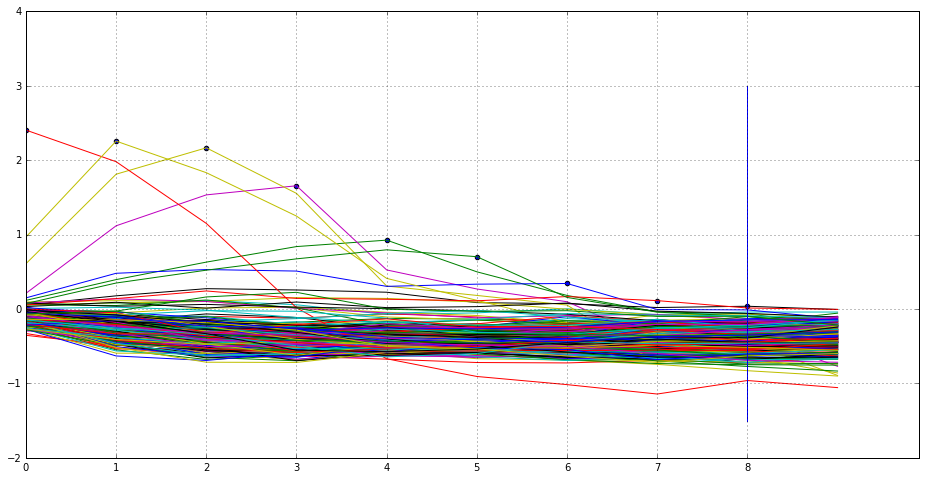

session # 5
 Labels:is_known(qv = 2.40466403961) -> 1.0(ref = 3.14371013641) |  decades_active:2000(qv = 2.2565369606) -> 1.0(ref = 3.74053096771) |  decades_active:2010(qv = 2.16628670692) -> 1.0(ref = 2.8847694397) |  last_activity:still_active(qv = 1.65644955635) -> 1.0(ref = 1.98396801949) |  Birth name:is_known(qv = 1.03575587273) -> 1.0(ref = 1.17906928062) |  decades_active:1990(qv = 0.858678042889) -> 1.0(ref = 0.188493967056) |  decades_active:1980(qv = 0.42901545763) -> -1.0(ref = -0.854216873646) |  Website:is_known(qv = 0.153455927968) -> 1.0(ref = 0.0500000119209) |  category:List_of_alternative_country_musicians(qv = -0.551444411278) -> -1.0(ref = -1.0) |  Instruments:vocals(qv = -0.0204776711762) -> 0.0(ref = 0.0) | reached max session length


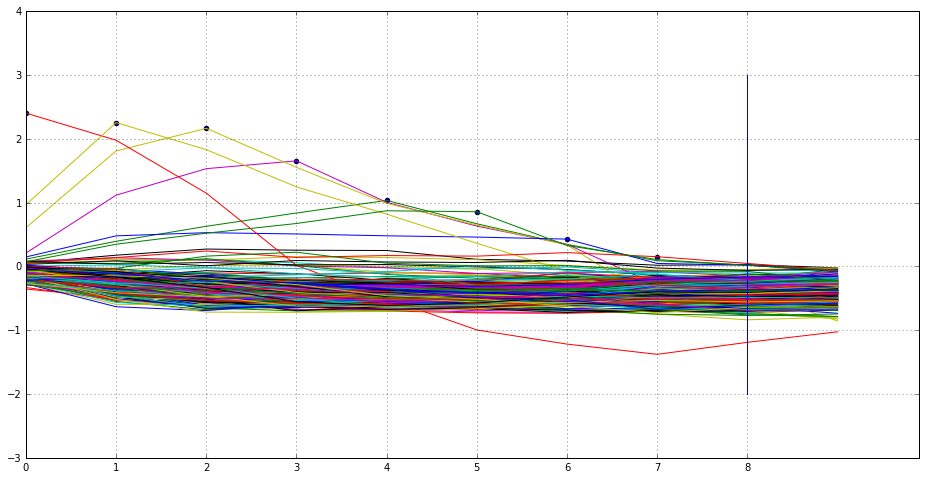

session # 6
 Labels:is_known(qv = 2.40466403961) -> 1.0(ref = 3.14371013641) |  decades_active:2000(qv = 2.2565369606) -> 1.0(ref = 1.84108018875) |  decades_active:2010(qv = 2.16628670692) -> 1.0(ref = 0.885347664356) |  last_activity:still_active(qv = 1.65644955635) -> -1.0(ref = -0.120686650276) |  Birth name:is_known(qv = 0.925593018532) -> 1.0(ref = 2.98274731636) |  decades_active:1990(qv = 0.703073382378) -> 1.0(ref = 2.08710241318) |  decades_active:1980(qv = 0.342961639166) -> 1.0(ref = 1.144318223) |  decades_active:1980(qv = 0.151913896203) -> -0.5(ref = -1.45000004768) |  Website:is_known(qv = 0.120401084423) -> -1.0(ref = -1.0) |  Instruments:vocals(qv = 0.0466755591333) -> 0.0(ref = 0.0) | reached max session length


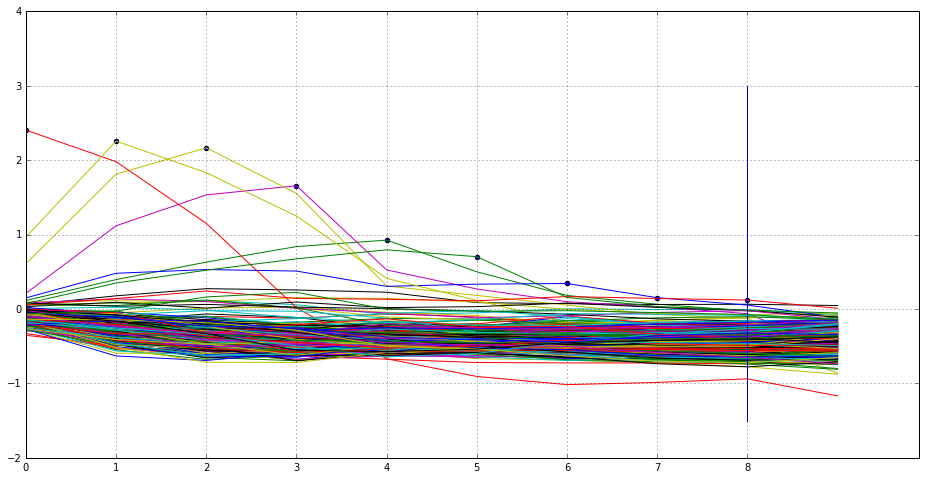

session # 7
 Labels:is_known(qv = 2.40466403961) -> 1.0(ref = 3.14371013641) |  decades_active:2000(qv = 2.2565369606) -> 1.0(ref = 3.74053096771) |  decades_active:2010(qv = 2.16628670692) -> 1.0(ref = 2.8847694397) |  last_activity:still_active(qv = 1.65644955635) -> 1.0(ref = 1.98396801949) |  Birth name:is_known(qv = 1.03575587273) -> 1.0(ref = 1.20620012283) |  decades_active:1990(qv = 0.858678042889) -> 1.0(ref = 0.217052817345) |  category:List_of_Christian_hip_hop_and_rap_artists(qv = -0.277237832546) -> -1.0(ref = -0.824154913425) |  decades_active:1990(qv = 0.185100093484) -> -0.5(ref = 0.449999988079) |  decades_active:1980(qv = 0.134718000889) -> 1.0(ref = 1.0) |  Website:is_known(qv = 0.0883725658059) -> 0.0(ref = 0.0) | reached max session length


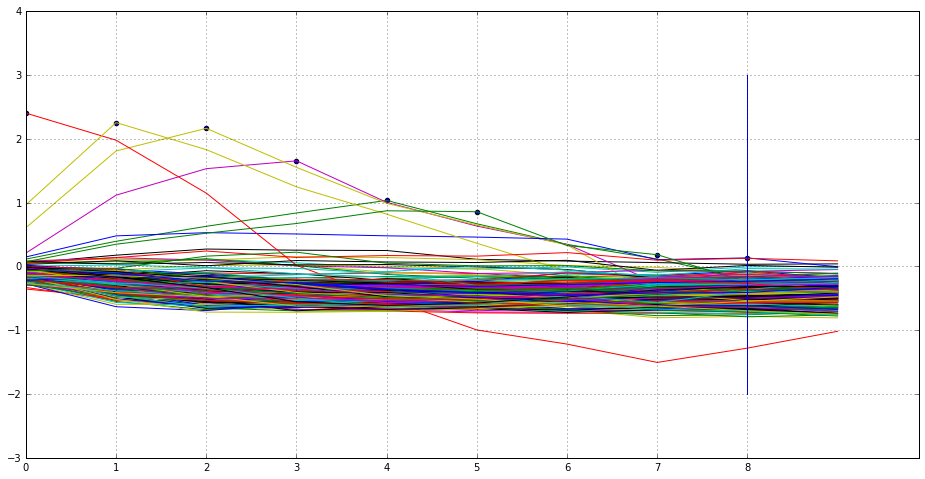

session # 8
 Labels:is_known(qv = 2.40466403961) -> -1.0(ref = 0.712361097336) |  decades_active:2000(qv = 1.80248534679) -> 1.0(ref = 3.65028595924) |  decades_active:2010(qv = 1.72124612331) -> 1.0(ref = 2.7897746563) |  last_activity:still_active(qv = 1.43494474888) -> 1.0(ref = 1.88397336006) |  Birth name:is_known(qv = 0.930498301983) -> 1.0(ref = 3.05079126358) |  decades_active:1990(qv = 0.769125819206) -> 1.0(ref = 2.15872764587) |  decades_active:1980(qv = 0.427124232054) -> 1.0(ref = 1.21971321106) |  last_activity:still_active(qv = 0.231277108192) -> -0.5(ref = -0.975000023842) |  decades_active:1990(qv = 0.278068363667) -> -0.5(ref = -0.5) |  decades_active:1980(qv = 0.188969910145) -> 0.0(ref = 0.0) | reached max session length


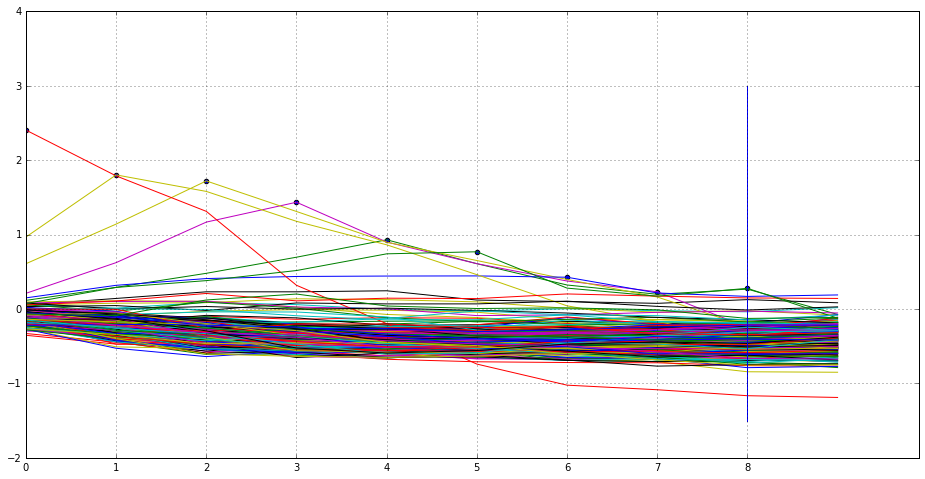

session # 9
 Labels:is_known(qv = 2.40466403961) -> -1.0(ref = 0.712361097336) |  decades_active:2000(qv = 1.80248534679) -> 1.0(ref = 3.65028595924) |  decades_active:2010(qv = 1.72124612331) -> 1.0(ref = 2.7897746563) |  last_activity:still_active(qv = 1.43494474888) -> 1.0(ref = 1.88397336006) |  Birth name:is_known(qv = 0.930498301983) -> 1.0(ref = 3.05079126358) |  decades_active:1990(qv = 0.769125819206) -> 1.0(ref = 2.15872764587) |  decades_active:1980(qv = 0.427124232054) -> 1.0(ref = 1.21971321106) |  last_activity:still_active(qv = 0.231277108192) -> -0.5(ref = -0.975000023842) |  decades_active:1990(qv = 0.278068363667) -> -0.5(ref = -0.5) |  decades_active:1980(qv = 0.188969910145) -> 0.0(ref = 0.0) | reached max session length


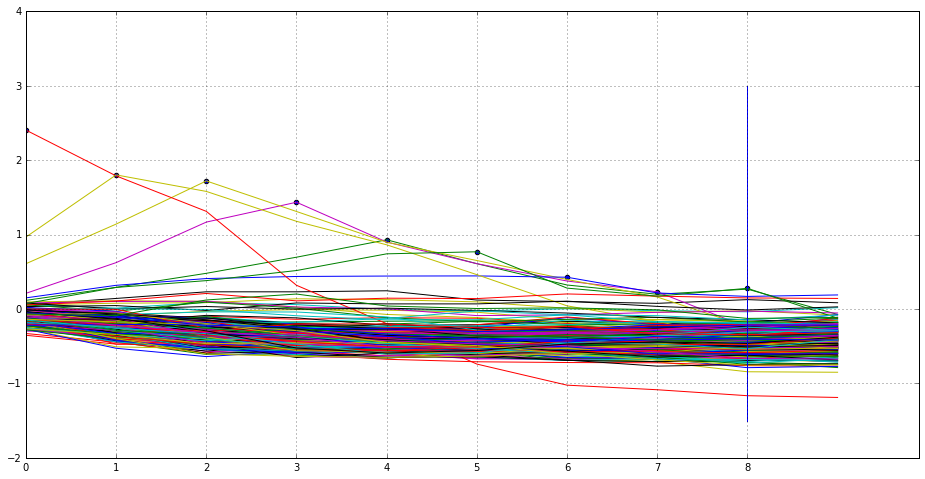

In [35]:
print "Random session examples"
env.load_random_batch(train_attrs,train_cats,10)
display_sessions(with_plots=True)
